ПИ19-3 Деменчук Георгий<br>
Лабораторная 6

# 6. Классификация текстов при помощи сверточных сетей

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г. 

## 1. Представление и предобработка текстовых данных в виде последовательностей

In [1]:
from platform import python_version

print(python_version())

3.8.13


In [2]:
import nltk
import re
import json

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


from typing import List, Dict
from collections import defaultdict
from functools import lru_cache
from pathlib import Path
from nltk.corpus import stopwords, wordnet
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset, random_split

1.1 Представьте первое предложение из строки `text` как последовательность из индексов слов, входящих в это предложение

In [3]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [4]:

def text2vector(text: str, bag: Dict[str, int]) -> List[int]:
    patched_words = text.lower().split(" ")
    return [bag[word] for word in patched_words]

In [5]:
words_set = set(map(lambda x: x.lower(), text.split(" ")))
bag_router_dict = {word : index for index, word in enumerate(words_set)}
bag_router_dict

{'represents': 0,
 'select': 1,
 'most': 2,
 'currently': 3,
 'tested': 4,
 'that': 5,
 'available': 6,
 'of': 7,
 'only': 8,
 'stable': 9,
 'run': 10,
 'note': 11,
 'preferences': 12,
 'version': 13,
 'the': 14,
 'is': 15,
 'libtorch': 16,
 'pytorch.': 17,
 'and': 18,
 'c++': 19,
 'your': 20,
 'for': 21,
 'command.': 22,
 'install': 23,
 'supported': 24}

In [6]:
text2vector(text, bag_router_dict)

[1,
 20,
 12,
 18,
 10,
 14,
 23,
 22,
 9,
 0,
 14,
 2,
 3,
 4,
 18,
 24,
 13,
 7,
 17,
 11,
 5,
 16,
 15,
 8,
 6,
 21,
 19]

1.2 Представьте первое предложение из строки `text` как последовательность векторов, соответствующих индексам слов. Для представления индекса в виде вектора используйте унитарное кодирование. В результате должен получиться двумерный тензор размера `количество слов в предложении` x `количество уникальных слов`

In [7]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [8]:
text = text.lower()
text

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c++'

In [9]:
#Формируем dict с ассоциацией слово -> таргет (индекс)
target = list(set(nltk.word_tokenize(text.replace(".", ""))))
word2index = {word: count for count, word in enumerate(target)}
word2index

{'represents': 0,
 'select': 1,
 'most': 2,
 'currently': 3,
 'tested': 4,
 'that': 5,
 'pytorch': 6,
 'available': 7,
 'of': 8,
 'only': 9,
 'stable': 10,
 'run': 11,
 'note': 12,
 'preferences': 13,
 'version': 14,
 'the': 15,
 'is': 16,
 'libtorch': 17,
 'and': 18,
 'c++': 19,
 'your': 20,
 'command': 21,
 'for': 22,
 'install': 23,
 'supported': 24}

In [10]:
#Берем первое предложение для процессинга
sentence_str = nltk.sent_tokenize(text)[0].replace(".", "")
sentence_str

'select your preferences and run the install command'

In [11]:
#Получаем список слов в предложении
words_list = nltk.word_tokenize(sentence_str)
words_list

['select', 'your', 'preferences', 'and', 'run', 'the', 'install', 'command']

In [12]:
#Создаем нулевой вектор по нашей длине
vectors = torch.zeros(len(words_list), len(target))
vectors

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])

In [13]:
#Получаем список, содержащий индекс слова и его закодированную цифру
indices = [(index, word2index[word]) for index, word in enumerate(words_list)]
indices

[(0, 1), (1, 20), (2, 13), (3, 18), (4, 11), (5, 15), (6, 23), (7, 21)]

In [14]:
#Формируем маску, по которой будем вставлять единицу в тензор
current_mask = list(zip(*indices))
current_mask

[(0, 1, 2, 3, 4, 5, 6, 7), (1, 20, 13, 18, 11, 15, 23, 21)]

In [15]:
#Получаем итоговый результат 
vectors[current_mask] = 1
vectors

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0.]])

In [16]:
indices_old = indices

1.3 Решите задачу 1.2, используя модуль `nn.Embedding`

In [17]:
#Это чтоб случайного фактора не было и рандомных значений
torch.manual_seed(0)

In [18]:
len(target)

25

In [19]:
#Создаем объект эмбединга
embeds = nn.Embedding(num_embeddings=len(target), embedding_dim=len(target))
embeds

Embedding(25, 25)

In [20]:
#
indices = torch.tensor([word2index[w] for w in nltk.word_tokenize(sentence_str)])
indices

tensor([ 1, 20, 13, 18, 11, 15, 23, 21])

In [21]:
assert list(map(lambda x: x[1], indices_old)) == list(map(lambda x: x.item(), indices))

Текущие индексы совпали с индексами предыдущего задания - уже хорошо!

In [22]:
#Получаем эмбединги по нашим индексам
embeds(indices)

tensor([[-0.5855, -0.1734,  0.1835,  1.3894,  1.5863,  0.9463, -0.8437, -0.6136,
          0.0316, -0.4927,  0.2484,  0.4397,  0.1124,  0.6408,  0.4412, -0.1023,
          0.7924, -0.2897,  0.0525,  0.5229,  2.3022, -1.4689, -1.5867, -0.6731,
          0.8728],
        [-0.1642, -0.9715, -1.0308,  0.6473, -0.1906,  0.7167, -2.0002, -2.4097,
          0.2194, -1.6989,  1.3094, -1.6613, -0.5461, -0.6302, -0.6347,  0.9747,
          0.2098,  0.0299,  1.7092, -0.7258, -0.7735,  0.5962, -1.2504,  1.1456,
          0.7393],
        [ 1.0077,  1.0046, -0.4335, -1.2426,  1.2846,  0.2438,  0.5304, -0.0145,
         -2.2357,  1.4660, -1.2191,  0.6442,  3.9300, -0.1244,  0.2953,  0.3827,
         -0.5497, -0.9940,  1.3459,  1.9457, -1.2904, -2.3495, -2.0689,  0.9094,
         -0.6946],
        [ 1.8024, -1.0597,  3.4028, -0.5687, -0.4755,  1.7432, -0.2044, -0.3164,
          1.2937,  1.3453,  0.1939,  1.5717, -0.3827,  1.3951,  0.3427, -1.6045,
         -0.5873,  0.6004,  0.4378, -0.0965,  0.3303

## 2. Классификация фамилий по национальности (ConvNet)

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`

2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса> 
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины

2.6. Обучить классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта: 
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

2.1 Считать файл `surnames/surnames.csv`. 

In [23]:
df = pd.read_csv("./data/surnames.csv")
df

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian
...,...,...
10975,Quraishi,Arabic
10976,Innalls,English
10977,Król,Polish
10978,Purvis,English


2.2 Закодировать национальности числами, начиная с 0.

Используем LabelEncoder 

In [24]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["nationality"])
df

,surname,nationality,label
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14
...,...,...,...
10975,Quraishi,Arabic,0
10976,Innalls,English,4
10977,Król,Polish,12
10978,Purvis,English,4


Кол-во классов:

In [25]:
len(set(df["label"].unique()))

18

In [26]:
assert len(set(df["label"].unique())) == len(label_encoder.classes_)

Если ошибки нет - енкодер работает нормально. Если есть - все плохо

2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`


In [27]:
class Vocab:
    
    #Строка, которая символизирует отступ
    PAD = "<PAD>"

    def __init__(self, series):
        
        
        #Нужен, чтоб хранить уникальные слова
        items_set = set()
        
        #Штука, которая нужна, чтоб определить макс вектор, чтоб потом заполнить pad ами
        max_len = 0
        
        #Формируем список слов + ищем max_len
        for word in map(str.lower, series):
            items_set.update(word)
            
            if len(word) > max_len:
                max_len = len(word)
                
        #Общий алфавит
        self.alphabet = [self.PAD, *items_set]
        
        self.max_len = max_len
        
        #Формируем транслятор слово -> таргет
        self.word_to_number_router = {item: number for number, item in enumerate(self.alphabet)}
        
    def decode(self, indices):
        """Метод декодинга"""
        
        #Маска по индексам-заглушкам
        mask = indices == self.word_to_number_router[self.PAD]
        
        #Сами индексы заглушек
        pad_indices = torch.nonzero(mask, as_tuple=True)[0]
        
        
        if len(pad_indices) != 0:
            indices = indices[:pad_indices[0]]  # отрезаем служебные символы
        
        return "".join(self.alphabet[i] for i in indices)
        
    def encode(self, word):
        """Метод енкодинга"""
        
        #Список индексов
        indices_list = [self.word_to_number_router[item] for item in word]
        
        #Индекс заглушки
        pad_index = self.word_to_number_router[self.PAD]
        
        #Разница, на которую надо дополнить слово
        len_diff = self.max_len - len(indices_list)
        
        # дополняем до одинакового размера индексом служебного символа
        indices_list +=  len_diff * [pad_index]
        
        return torch.tensor(indices_list, dtype=torch.long)

    def __repr__(self) -> str:
        return json.dumps(self.word_to_number_router, ensure_ascii=False)
    
    def __len__(self):
          return len(self.word_to_number_router)
    

In [28]:
vocab = Vocab(df["surname"])

In [29]:
vocab.word_to_number_router

{'<PAD>': 0,
 'ê': 1,
 'w': 2,
 'ù': 3,
 ':': 4,
 'ã': 5,
 'r': 6,
 'b': 7,
 'ò': 8,
 'è': 9,
 'ł': 10,
 'á': 11,
 'í': 12,
 'd': 13,
 'õ': 14,
 '1': 15,
 'p': 16,
 'ä': 17,
 'ú': 18,
 'i': 19,
 'ü': 20,
 "'": 21,
 's': 22,
 'z': 23,
 'ì': 24,
 'q': 25,
 'ß': 26,
 'c': 27,
 'j': 28,
 'h': 29,
 'ż': 30,
 'ç': 31,
 'a': 32,
 'à': 33,
 'ö': 34,
 'g': 35,
 'ó': 36,
 'l': 37,
 'o': 38,
 'n': 39,
 'e': 40,
 'é': 41,
 '-': 42,
 'ą': 43,
 'ñ': 44,
 'y': 45,
 'ś': 46,
 'f': 47,
 'm': 48,
 'ń': 49,
 't': 50,
 '/': 51,
 'x': 52,
 'u': 53,
 'v': 54,
 'k': 55}

In [30]:
len(vocab)

56

In [31]:
print(vocab)

{"<PAD>": 0, "ê": 1, "w": 2, "ù": 3, ":": 4, "ã": 5, "r": 6, "b": 7, "ò": 8, "è": 9, "ł": 10, "á": 11, "í": 12, "d": 13, "õ": 14, "1": 15, "p": 16, "ä": 17, "ú": 18, "i": 19, "ü": 20, "'": 21, "s": 22, "z": 23, "ì": 24, "q": 25, "ß": 26, "c": 27, "j": 28, "h": 29, "ż": 30, "ç": 31, "a": 32, "à": 33, "ö": 34, "g": 35, "ó": 36, "l": 37, "o": 38, "n": 39, "e": 40, "é": 41, "-": 42, "ą": 43, "ñ": 44, "y": 45, "ś": 46, "f": 47, "m": 48, "ń": 49, "t": 50, "/": 51, "x": 52, "u": 53, "v": 54, "k": 55}


#### Проверяем с дополнениями PADами

Энкодинг

In [32]:
test_str = "test"

In [33]:
encode_result = vocab.encode(test_str)
encode_result

tensor([50, 40, 22, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Декодинг

In [34]:
decode_result = vocab.decode(encode_result)
decode_result

'test'

In [35]:
assert test_str == decode_result

Если ошибки нет - ОК

#### Проверяем без дополнений PADами

Энкодинг

In [36]:
test_str = "test"* 5

In [37]:
encode_result = vocab.encode(test_str)
encode_result

tensor([50, 40, 22, 50, 50, 40, 22, 50, 50, 40, 22, 50, 50, 40, 22, 50, 50, 40,
        22, 50])

Декодинг

In [38]:
decode_result = vocab.decode(encode_result)
decode_result

'testtesttesttesttest'

In [39]:
assert test_str == decode_result

2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса>
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины


Объявляем SurnamesDataset для индексов

In [40]:
class SurnamesDatasetIndices(Dataset):
    def __init__(self, X, y, vocab):
            self.X = X
            self.y = y
            self.vocab = vocab

    def processing(self, surname):
        res = [self.vocab.word_to_number_router[token] for token in surname]
        if len(res) != self.vocab.max_len: 
            res.extend([self.vocab.word_to_number_router["<PAD>"]]*(self.vocab.max_len-len(res)))    
        return res
    
    def __len__(self):
        return len(self.X)
  
    def __getitem__(self, idx):
        return torch.LongTensor(self.processing(self.X.iloc[idx])), self.y.iloc[idx]

In [41]:
class SurnamesDatasetOnehot(Dataset):
    def __init__(self, X, y, vocab):
            self.X = X
            self.y = y
            self.vocab = vocab
            
    def processing(self, surname):
        res = [nn.functional.one_hot(torch.arange(0, len(self.vocab)))[self.vocab.word_to_number_router[token]] for token in surname]
        while len(res) < self.vocab.max_len:
            res.append(nn.functional.one_hot(torch.arange(0, len(self.vocab)))[self.vocab.word_to_number_router["<PAD>"]])
        return torch.stack(res)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.LongTensor(self.processing(self.X.iloc[idx])), self.y.iloc[idx]


2.3 Разбить датасет на обучающую и тестовую выборку

In [42]:
X = df['surname'].str.lower()
y = df['label']
n_classes = y.nunique()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
df

,surname,nationality,label
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14
...,...,...,...
10975,Quraishi,Arabic,0
10976,Innalls,English,4
10977,Król,Polish,12
10978,Purvis,English,4


In [44]:
torch.manual_seed(0)

In [45]:
X_train

8996         leese
7868       evdakov
6109      severins
5417           zhu
5194        copley
           ...    
4859     terranova
3264          ruiz
9845         gagin
10799    crossland
2732        hoteev
Name: surname, Length: 8784, dtype: object

In [46]:
y_train

8996      4
7868     14
6109      3
5417      1
5194      4
         ..
4859      9
3264     16
9845     14
10799     4
2732     14
Name: label, Length: 8784, dtype: int64

In [47]:
train_dataset = SurnamesDatasetIndices(X_train, y_train, vocab)
test_dataset = SurnamesDatasetIndices(X_test, y_test, vocab)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

print(f"Train dataset: {len(train_dataset)}")
print(f"Test dataset: {len(test_dataset)}")

Train dataset: 8784
Test dataset: 2196


In [48]:
train_dataset_onehot = SurnamesDatasetOnehot(X_train, y_train, vocab)
test_dataset_onehot = SurnamesDatasetOnehot(X_test, y_test, vocab)
train_loader_onehot = DataLoader(train_dataset_onehot, batch_size=128, shuffle=True)
test_loader_onehot = DataLoader(test_dataset_onehot, batch_size=128, shuffle=True)
print(f"Train dataset: {len(train_dataset_onehot)}")
print(f"Test dataset: {len(test_dataset_onehot)}")

Train dataset: 8784
Test dataset: 2196


2.6. Обучить классификатор.

  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта:
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`


In [49]:
class SurnameModel(nn.Module):
    def __init__(self, embed_num, embed_dim, classes_num, seq_len, use_embed=True):
        super(SurnameModel, self).__init__()

        self.embed_dim = embed_dim
        self.use_embed = use_embed
        self.seq_len = seq_len
        
        if self.use_embed:
            self.embed = nn.Embedding(embed_num, embed_dim)
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=3)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(64, classes_num)

    def forward(self, x):
        if self.use_embed:
            x = self.embed(x)
        # print(x.shape)
        x = x.reshape(len(x), self.embed_dim, self.seq_len).type(torch.FloatTensor)
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x, _ = x.max(dim=-1)

        return self.fc1(x)


Часть 1. Использование SurnamesDatasetOneHot

In [50]:
from sklearn.metrics import accuracy_score

In [51]:


model = SurnameModel(
    len(vocab), len(vocab), n_classes, vocab.max_len, use_embed=False
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 100

losses_plt = []
val_loss_plt = []

for epoch in range(n_epochs):
    print(f"\n-------------------------------\nEpoch {epoch+1}")
    epoch_loss = 0
    for X_batch, y_batch in train_loader_onehot:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader_onehot:
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch).item()
            acc = accuracy_score(
                y_batch, predictions.argmax(dim=1).cpu().detach()
            ).item()
            
            train_loss = epoch_loss / len(train_loader)
            
            val_loss += loss
            val_acc += acc

            print(
                f"Training loss: {train_loss:>7f} val_loss: {val_loss:>7f}"
            )
    val_loss_plt.append(loss)
    losses_plt.append(train_loss)
            



-------------------------------
Epoch 1
Training loss: 2.360209 val_loss: 2.208647
Training loss: 2.360209 val_loss: 4.299854
Training loss: 2.360209 val_loss: 6.520063
Training loss: 2.360209 val_loss: 8.733138
Training loss: 2.360209 val_loss: 10.842815
Training loss: 2.360209 val_loss: 12.983523
Training loss: 2.360209 val_loss: 15.108531
Training loss: 2.360209 val_loss: 17.276256
Training loss: 2.360209 val_loss: 19.403130
Training loss: 2.360209 val_loss: 21.562572
Training loss: 2.360209 val_loss: 23.761525
Training loss: 2.360209 val_loss: 25.937197
Training loss: 2.360209 val_loss: 28.100948
Training loss: 2.360209 val_loss: 30.233779
Training loss: 2.360209 val_loss: 32.216707
Training loss: 2.360209 val_loss: 34.613997
Training loss: 2.360209 val_loss: 36.672063
Training loss: 2.360209 val_loss: 38.815406

-------------------------------
Epoch 2
Training loss: 2.094338 val_loss: 2.021687
Training loss: 2.094338 val_loss: 3.975897
Training loss: 2.094338 val_loss: 5.828416
T

Training loss: 1.274831 val_loss: 1.189356
Training loss: 1.274831 val_loss: 2.639882
Training loss: 1.274831 val_loss: 3.854414
Training loss: 1.274831 val_loss: 5.151101
Training loss: 1.274831 val_loss: 6.356714
Training loss: 1.274831 val_loss: 7.743552
Training loss: 1.274831 val_loss: 9.155919
Training loss: 1.274831 val_loss: 10.355160
Training loss: 1.274831 val_loss: 11.743147
Training loss: 1.274831 val_loss: 13.181829
Training loss: 1.274831 val_loss: 14.600397
Training loss: 1.274831 val_loss: 15.936769
Training loss: 1.274831 val_loss: 17.234391
Training loss: 1.274831 val_loss: 18.634105
Training loss: 1.274831 val_loss: 20.160924
Training loss: 1.274831 val_loss: 21.246912
Training loss: 1.274831 val_loss: 22.881245
Training loss: 1.274831 val_loss: 24.733719

-------------------------------
Epoch 12
Training loss: 1.239107 val_loss: 1.209997
Training loss: 1.239107 val_loss: 2.599321
Training loss: 1.239107 val_loss: 3.688721
Training loss: 1.239107 val_loss: 4.956136
T

Training loss: 0.978186 val_loss: 1.133569
Training loss: 0.978186 val_loss: 2.293564
Training loss: 0.978186 val_loss: 3.588014
Training loss: 0.978186 val_loss: 4.862314
Training loss: 0.978186 val_loss: 6.183886
Training loss: 0.978186 val_loss: 7.676450
Training loss: 0.978186 val_loss: 8.846577
Training loss: 0.978186 val_loss: 9.953993
Training loss: 0.978186 val_loss: 11.117188
Training loss: 0.978186 val_loss: 12.181066
Training loss: 0.978186 val_loss: 13.288953
Training loss: 0.978186 val_loss: 14.383808
Training loss: 0.978186 val_loss: 15.705010
Training loss: 0.978186 val_loss: 16.898635
Training loss: 0.978186 val_loss: 17.964649
Training loss: 0.978186 val_loss: 19.100787
Training loss: 0.978186 val_loss: 20.150750
Training loss: 0.978186 val_loss: 21.289429

-------------------------------
Epoch 22
Training loss: 0.951540 val_loss: 1.213972
Training loss: 0.951540 val_loss: 2.425733
Training loss: 0.951540 val_loss: 3.380510
Training loss: 0.951540 val_loss: 4.394135
Tr

Training loss: 0.790033 val_loss: 1.102375
Training loss: 0.790033 val_loss: 2.206045
Training loss: 0.790033 val_loss: 3.425804
Training loss: 0.790033 val_loss: 4.607440
Training loss: 0.790033 val_loss: 5.622220
Training loss: 0.790033 val_loss: 6.720249
Training loss: 0.790033 val_loss: 8.037368
Training loss: 0.790033 val_loss: 9.178987
Training loss: 0.790033 val_loss: 10.133147
Training loss: 0.790033 val_loss: 11.388840
Training loss: 0.790033 val_loss: 12.410851
Training loss: 0.790033 val_loss: 13.605168
Training loss: 0.790033 val_loss: 14.843202
Training loss: 0.790033 val_loss: 16.072685
Training loss: 0.790033 val_loss: 17.037265
Training loss: 0.790033 val_loss: 18.079430
Training loss: 0.790033 val_loss: 19.489620
Training loss: 0.790033 val_loss: 20.696749

-------------------------------
Epoch 32
Training loss: 0.776529 val_loss: 1.025332
Training loss: 0.776529 val_loss: 2.308851
Training loss: 0.776529 val_loss: 3.303529
Training loss: 0.776529 val_loss: 4.319906
Tr

Training loss: 0.664893 val_loss: 1.283874
Training loss: 0.664893 val_loss: 2.563929
Training loss: 0.664893 val_loss: 3.673313
Training loss: 0.664893 val_loss: 4.827126
Training loss: 0.664893 val_loss: 6.106913
Training loss: 0.664893 val_loss: 7.092544
Training loss: 0.664893 val_loss: 8.289335
Training loss: 0.664893 val_loss: 9.407728
Training loss: 0.664893 val_loss: 10.654916
Training loss: 0.664893 val_loss: 11.763675
Training loss: 0.664893 val_loss: 12.950206
Training loss: 0.664893 val_loss: 13.969875
Training loss: 0.664893 val_loss: 15.026409
Training loss: 0.664893 val_loss: 16.065636
Training loss: 0.664893 val_loss: 17.090190
Training loss: 0.664893 val_loss: 18.247187
Training loss: 0.664893 val_loss: 19.434577
Training loss: 0.664893 val_loss: 20.553915

-------------------------------
Epoch 42
Training loss: 0.650199 val_loss: 1.195435
Training loss: 0.650199 val_loss: 2.321217
Training loss: 0.650199 val_loss: 3.639876
Training loss: 0.650199 val_loss: 4.814538
Tr

Training loss: 0.574750 val_loss: 1.155070
Training loss: 0.574750 val_loss: 2.319988
Training loss: 0.574750 val_loss: 3.396321
Training loss: 0.574750 val_loss: 4.515793
Training loss: 0.574750 val_loss: 5.615627
Training loss: 0.574750 val_loss: 6.416178
Training loss: 0.574750 val_loss: 7.673260
Training loss: 0.574750 val_loss: 8.870044
Training loss: 0.574750 val_loss: 10.070740
Training loss: 0.574750 val_loss: 11.165156
Training loss: 0.574750 val_loss: 12.579489
Training loss: 0.574750 val_loss: 13.727276
Training loss: 0.574750 val_loss: 14.843877
Training loss: 0.574750 val_loss: 15.995178
Training loss: 0.574750 val_loss: 17.092618
Training loss: 0.574750 val_loss: 18.370803
Training loss: 0.574750 val_loss: 19.785767
Training loss: 0.574750 val_loss: 20.845336

-------------------------------
Epoch 52
Training loss: 0.563789 val_loss: 1.260514
Training loss: 0.563789 val_loss: 2.499973
Training loss: 0.563789 val_loss: 3.633573
Training loss: 0.563789 val_loss: 4.980806
Tr

Training loss: 0.494443 val_loss: 1.349521
Training loss: 0.494443 val_loss: 2.542823
Training loss: 0.494443 val_loss: 3.676106
Training loss: 0.494443 val_loss: 4.991475
Training loss: 0.494443 val_loss: 5.973038
Training loss: 0.494443 val_loss: 7.153744
Training loss: 0.494443 val_loss: 8.440565
Training loss: 0.494443 val_loss: 10.002237
Training loss: 0.494443 val_loss: 10.951899
Training loss: 0.494443 val_loss: 12.111218
Training loss: 0.494443 val_loss: 13.043526
Training loss: 0.494443 val_loss: 14.506379
Training loss: 0.494443 val_loss: 15.520959
Training loss: 0.494443 val_loss: 16.641828
Training loss: 0.494443 val_loss: 17.854711
Training loss: 0.494443 val_loss: 18.998376
Training loss: 0.494443 val_loss: 20.403436
Training loss: 0.494443 val_loss: 21.260209

-------------------------------
Epoch 62
Training loss: 0.488133 val_loss: 1.193697
Training loss: 0.488133 val_loss: 2.610164
Training loss: 0.488133 val_loss: 3.567172
Training loss: 0.488133 val_loss: 5.152170
T

Training loss: 0.437322 val_loss: 0.951687
Training loss: 0.437322 val_loss: 2.276752
Training loss: 0.437322 val_loss: 3.669141
Training loss: 0.437322 val_loss: 4.682346
Training loss: 0.437322 val_loss: 5.869683
Training loss: 0.437322 val_loss: 7.406472
Training loss: 0.437322 val_loss: 8.583688
Training loss: 0.437322 val_loss: 10.054292
Training loss: 0.437322 val_loss: 11.185776
Training loss: 0.437322 val_loss: 12.437458
Training loss: 0.437322 val_loss: 13.790448
Training loss: 0.437322 val_loss: 14.955850
Training loss: 0.437322 val_loss: 16.121894
Training loss: 0.437322 val_loss: 17.603726
Training loss: 0.437322 val_loss: 18.921605
Training loss: 0.437322 val_loss: 19.927489
Training loss: 0.437322 val_loss: 20.982325
Training loss: 0.437322 val_loss: 22.133500

-------------------------------
Epoch 72
Training loss: 0.432920 val_loss: 1.134494
Training loss: 0.432920 val_loss: 2.636985
Training loss: 0.432920 val_loss: 3.883938
Training loss: 0.432920 val_loss: 4.876829
T

Training loss: 0.387621 val_loss: 1.216391
Training loss: 0.387621 val_loss: 2.479975
Training loss: 0.387621 val_loss: 3.735050
Training loss: 0.387621 val_loss: 4.939018
Training loss: 0.387621 val_loss: 6.160046
Training loss: 0.387621 val_loss: 7.239874
Training loss: 0.387621 val_loss: 8.417215
Training loss: 0.387621 val_loss: 9.491518
Training loss: 0.387621 val_loss: 10.828139
Training loss: 0.387621 val_loss: 12.259640
Training loss: 0.387621 val_loss: 13.502369
Training loss: 0.387621 val_loss: 14.551386
Training loss: 0.387621 val_loss: 15.911417
Training loss: 0.387621 val_loss: 17.369574
Training loss: 0.387621 val_loss: 19.165309
Training loss: 0.387621 val_loss: 20.389190
Training loss: 0.387621 val_loss: 21.837049
Training loss: 0.387621 val_loss: 23.899904

-------------------------------
Epoch 82
Training loss: 0.381122 val_loss: 1.378098
Training loss: 0.381122 val_loss: 2.414092
Training loss: 0.381122 val_loss: 3.643870
Training loss: 0.381122 val_loss: 5.116892
Tr

Training loss: 0.338976 val_loss: 0.826101
Training loss: 0.338976 val_loss: 2.350599
Training loss: 0.338976 val_loss: 3.687489
Training loss: 0.338976 val_loss: 5.148770
Training loss: 0.338976 val_loss: 6.716207
Training loss: 0.338976 val_loss: 8.213400
Training loss: 0.338976 val_loss: 9.777735
Training loss: 0.338976 val_loss: 11.150378
Training loss: 0.338976 val_loss: 12.581968
Training loss: 0.338976 val_loss: 13.868355
Training loss: 0.338976 val_loss: 14.835014
Training loss: 0.338976 val_loss: 16.203877
Training loss: 0.338976 val_loss: 17.956657
Training loss: 0.338976 val_loss: 19.562025
Training loss: 0.338976 val_loss: 20.731043
Training loss: 0.338976 val_loss: 21.777208
Training loss: 0.338976 val_loss: 23.328542
Training loss: 0.338976 val_loss: 24.292642

-------------------------------
Epoch 92
Training loss: 0.345801 val_loss: 1.385624
Training loss: 0.345801 val_loss: 2.702360
Training loss: 0.345801 val_loss: 4.106443
Training loss: 0.345801 val_loss: 5.312630
T

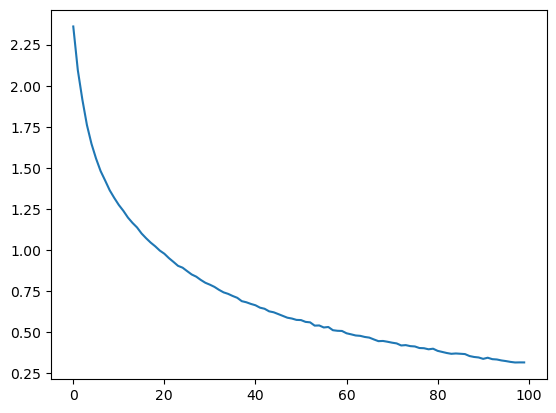

In [52]:
import matplotlib.pyplot as plt

plt.plot(torch.arange(len(losses_plt)), losses_plt)

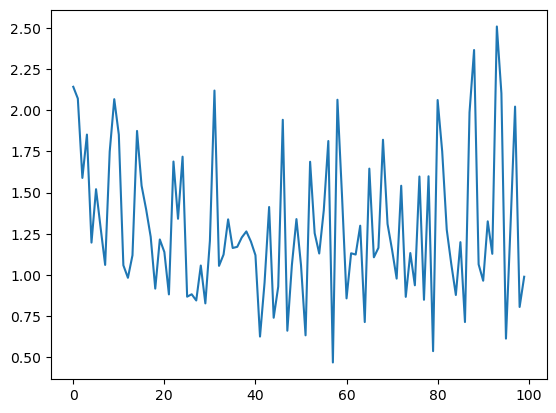

In [53]:
plt.plot(torch.arange(len(val_loss_plt)), val_loss_plt)

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [54]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

test_loader_onehot_2 = DataLoader(
    test_dataset_onehot, batch_size=len(test_dataset_onehot), shuffle=True
)
X_batch, y_batch = next(iter(test_loader_onehot_2))
predictions = model(X_batch).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       330
           1       0.50      0.78      0.61        32
           2       0.27      0.15      0.19        87
           3       0.33      0.29      0.30        49
           4       0.62      0.80      0.70       572
           5       0.11      0.05      0.07        38
           6       0.48      0.38      0.42       117
           7       0.39      0.44      0.41        27
           8       0.54      0.33      0.41        39
           9       0.54      0.51      0.53       120
          10       0.70      0.78      0.74       153
          11       0.25      0.12      0.17         8
          12       0.62      0.19      0.29        27
          13       0.00      0.00      0.00         9
          14       0.83      0.76      0.79       502
          15       0.00      0.00      0.00        23
          16       0.31      0.20      0.24        46
          17       0.20    

In [55]:
# Проверяем работу модели на наших данных
names_list = [
    "Demenchuk",
    "Baranov",
    "Fogel",
    "Newman"
]

targets_list = ["Russian","Russian", "German", "English"]

for name, target in zip(map(lambda x: x.lower(), names_list), targets_list):
    x = torch.LongTensor(train_dataset_onehot.processing(name)).unsqueeze(0)
    output = model(x).cpu().detach().numpy()
    predictions = output.argsort()[0][-3:][::-1]
    predictions_names = label_encoder.inverse_transform(predictions)
    print(f"Surname : {name}")
    print(f"True    : {target}")
    print(f"Predicts: {predictions}")
    print(f"Predicts names: {predictions_names}\n")
    


Surname : demenchuk
True    : Russian
Predicts: [14  2 12]
Predicts names: ['Russian' 'Czech' 'Polish']

Surname : baranov
True    : Russian
Predicts: [14  7  9]
Predicts names: ['Russian' 'Greek' 'Italian']

Surname : fogel
True    : German
Predicts: [9 4 5]
Predicts names: ['Italian' 'English' 'French']

Surname : newman
True    : English
Predicts: [4 8 6]
Predicts names: ['English' 'Irish' 'German']



Часть 2. Использование OneHot

In [56]:
model = SurnameModel(len(vocab), 30, n_classes, vocab.max_len, use_embed=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 100

losses_plt = []
val_loss_plt = []

for epoch in range(n_epochs):
    print(f"\n-------------------------------\nEpoch {epoch+1}")
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch).item()
            acc = accuracy_score(
                y_batch, predictions.argmax(dim=1).cpu().detach()
            ).item()
            
            train_loss = epoch_loss / len(train_loader)
            
            val_loss += loss
            val_acc += acc
            print(
                f"Training loss: {train_loss:>7f} val_loss: {val_loss:>7f}"
            )
    val_loss_plt.append(loss)
    losses_plt.append(train_loss)



-------------------------------
Epoch 1
Training loss: 2.148005 val_loss: 2.085783
Training loss: 2.148005 val_loss: 3.991299
Training loss: 2.148005 val_loss: 5.900876
Training loss: 2.148005 val_loss: 7.718128
Training loss: 2.148005 val_loss: 9.620062
Training loss: 2.148005 val_loss: 11.566992
Training loss: 2.148005 val_loss: 13.448728
Training loss: 2.148005 val_loss: 15.409245
Training loss: 2.148005 val_loss: 17.270909
Training loss: 2.148005 val_loss: 19.141243
Training loss: 2.148005 val_loss: 21.083915
Training loss: 2.148005 val_loss: 22.900929
Training loss: 2.148005 val_loss: 25.186641
Training loss: 2.148005 val_loss: 27.123489
Training loss: 2.148005 val_loss: 29.085564
Training loss: 2.148005 val_loss: 31.105115
Training loss: 2.148005 val_loss: 33.156576
Training loss: 2.148005 val_loss: 35.239833

-------------------------------
Epoch 2
Training loss: 1.833997 val_loss: 1.865006
Training loss: 1.833997 val_loss: 3.639545
Training loss: 1.833997 val_loss: 5.395512
Tr

Training loss: 0.908418 val_loss: 1.111237
Training loss: 0.908418 val_loss: 2.058102
Training loss: 0.908418 val_loss: 3.297399
Training loss: 0.908418 val_loss: 4.515631
Training loss: 0.908418 val_loss: 5.759233
Training loss: 0.908418 val_loss: 6.850205
Training loss: 0.908418 val_loss: 7.812780
Training loss: 0.908418 val_loss: 9.128279
Training loss: 0.908418 val_loss: 10.272290
Training loss: 0.908418 val_loss: 11.285829
Training loss: 0.908418 val_loss: 12.414323
Training loss: 0.908418 val_loss: 13.413129
Training loss: 0.908418 val_loss: 14.563300
Training loss: 0.908418 val_loss: 15.714944
Training loss: 0.908418 val_loss: 16.612140
Training loss: 0.908418 val_loss: 17.609543
Training loss: 0.908418 val_loss: 18.735417
Training loss: 0.908418 val_loss: 19.377296

-------------------------------
Epoch 12
Training loss: 0.863056 val_loss: 1.154264
Training loss: 0.863056 val_loss: 2.132797
Training loss: 0.863056 val_loss: 3.023446
Training loss: 0.863056 val_loss: 4.260466
Tr

Training loss: 0.577114 val_loss: 1.171680
Training loss: 0.577114 val_loss: 2.324694
Training loss: 0.577114 val_loss: 3.334510
Training loss: 0.577114 val_loss: 4.284086
Training loss: 0.577114 val_loss: 5.331997
Training loss: 0.577114 val_loss: 6.705090
Training loss: 0.577114 val_loss: 7.859260
Training loss: 0.577114 val_loss: 8.931847
Training loss: 0.577114 val_loss: 10.184288
Training loss: 0.577114 val_loss: 11.086658
Training loss: 0.577114 val_loss: 12.050851
Training loss: 0.577114 val_loss: 13.075402
Training loss: 0.577114 val_loss: 14.136769
Training loss: 0.577114 val_loss: 15.281577
Training loss: 0.577114 val_loss: 16.508957
Training loss: 0.577114 val_loss: 17.584977
Training loss: 0.577114 val_loss: 18.580881
Training loss: 0.577114 val_loss: 19.764508

-------------------------------
Epoch 22
Training loss: 0.559467 val_loss: 1.037836
Training loss: 0.559467 val_loss: 2.181167
Training loss: 0.559467 val_loss: 3.131415
Training loss: 0.559467 val_loss: 4.050889
Tr

Training loss: 0.388432 val_loss: 1.347626
Training loss: 0.388432 val_loss: 2.465030
Training loss: 0.388432 val_loss: 3.601331
Training loss: 0.388432 val_loss: 4.950714
Training loss: 0.388432 val_loss: 5.906180
Training loss: 0.388432 val_loss: 6.819497
Training loss: 0.388432 val_loss: 8.034585
Training loss: 0.388432 val_loss: 9.073078
Training loss: 0.388432 val_loss: 10.691364
Training loss: 0.388432 val_loss: 11.800587
Training loss: 0.388432 val_loss: 12.669409
Training loss: 0.388432 val_loss: 13.663736
Training loss: 0.388432 val_loss: 14.866581
Training loss: 0.388432 val_loss: 16.312852
Training loss: 0.388432 val_loss: 17.395045
Training loss: 0.388432 val_loss: 18.590613
Training loss: 0.388432 val_loss: 19.776111
Training loss: 0.388432 val_loss: 20.393691

-------------------------------
Epoch 32
Training loss: 0.369357 val_loss: 1.525420
Training loss: 0.369357 val_loss: 3.075622
Training loss: 0.369357 val_loss: 3.961779
Training loss: 0.369357 val_loss: 5.087526
Tr

Training loss: 0.255944 val_loss: 1.317005
Training loss: 0.255944 val_loss: 2.425640
Training loss: 0.255944 val_loss: 3.587955
Training loss: 0.255944 val_loss: 4.878218
Training loss: 0.255944 val_loss: 6.235497
Training loss: 0.255944 val_loss: 7.324030
Training loss: 0.255944 val_loss: 8.994168
Training loss: 0.255944 val_loss: 10.364470
Training loss: 0.255944 val_loss: 11.626231
Training loss: 0.255944 val_loss: 12.840127
Training loss: 0.255944 val_loss: 14.317050
Training loss: 0.255944 val_loss: 15.636230
Training loss: 0.255944 val_loss: 16.817906
Training loss: 0.255944 val_loss: 18.062905
Training loss: 0.255944 val_loss: 19.227856
Training loss: 0.255944 val_loss: 20.774354
Training loss: 0.255944 val_loss: 21.885546
Training loss: 0.255944 val_loss: 23.193908

-------------------------------
Epoch 42
Training loss: 0.253551 val_loss: 1.349486
Training loss: 0.253551 val_loss: 2.495104
Training loss: 0.253551 val_loss: 3.687165
Training loss: 0.253551 val_loss: 4.851449
T

Training loss: 0.184464 val_loss: 1.181141
Training loss: 0.184464 val_loss: 2.479349
Training loss: 0.184464 val_loss: 3.923877
Training loss: 0.184464 val_loss: 5.966313
Training loss: 0.184464 val_loss: 7.446319
Training loss: 0.184464 val_loss: 8.672926
Training loss: 0.184464 val_loss: 10.459875
Training loss: 0.184464 val_loss: 12.158976
Training loss: 0.184464 val_loss: 13.636247
Training loss: 0.184464 val_loss: 15.297699
Training loss: 0.184464 val_loss: 16.643024
Training loss: 0.184464 val_loss: 18.187941
Training loss: 0.184464 val_loss: 19.644872
Training loss: 0.184464 val_loss: 21.299440
Training loss: 0.184464 val_loss: 22.660961
Training loss: 0.184464 val_loss: 23.827120
Training loss: 0.184464 val_loss: 25.048948
Training loss: 0.184464 val_loss: 26.468333

-------------------------------
Epoch 52
Training loss: 0.175734 val_loss: 1.385901
Training loss: 0.175734 val_loss: 2.841712
Training loss: 0.175734 val_loss: 4.303951
Training loss: 0.175734 val_loss: 5.883683


Training loss: 0.135903 val_loss: 1.718724
Training loss: 0.135903 val_loss: 3.393945
Training loss: 0.135903 val_loss: 4.848736
Training loss: 0.135903 val_loss: 6.451017
Training loss: 0.135903 val_loss: 7.929228
Training loss: 0.135903 val_loss: 10.126845
Training loss: 0.135903 val_loss: 11.861144
Training loss: 0.135903 val_loss: 13.813496
Training loss: 0.135903 val_loss: 15.254621
Training loss: 0.135903 val_loss: 16.857823
Training loss: 0.135903 val_loss: 18.983489
Training loss: 0.135903 val_loss: 20.477283
Training loss: 0.135903 val_loss: 21.889310
Training loss: 0.135903 val_loss: 23.352416
Training loss: 0.135903 val_loss: 24.891419
Training loss: 0.135903 val_loss: 26.659584
Training loss: 0.135903 val_loss: 28.343625
Training loss: 0.135903 val_loss: 30.311641

-------------------------------
Epoch 62
Training loss: 0.132569 val_loss: 1.699945
Training loss: 0.132569 val_loss: 3.196678
Training loss: 0.132569 val_loss: 5.227172
Training loss: 0.132569 val_loss: 6.644925

Training loss: 0.122861 val_loss: 1.704589
Training loss: 0.122861 val_loss: 3.445279
Training loss: 0.122861 val_loss: 5.502851
Training loss: 0.122861 val_loss: 7.195051
Training loss: 0.122861 val_loss: 8.857367
Training loss: 0.122861 val_loss: 10.489694
Training loss: 0.122861 val_loss: 12.733351
Training loss: 0.122861 val_loss: 14.642787
Training loss: 0.122861 val_loss: 16.590601
Training loss: 0.122861 val_loss: 18.470652
Training loss: 0.122861 val_loss: 20.059657
Training loss: 0.122861 val_loss: 21.782158
Training loss: 0.122861 val_loss: 23.745773
Training loss: 0.122861 val_loss: 25.379578
Training loss: 0.122861 val_loss: 27.641340
Training loss: 0.122861 val_loss: 29.352119
Training loss: 0.122861 val_loss: 31.041283
Training loss: 0.122861 val_loss: 32.136930

-------------------------------
Epoch 72
Training loss: 0.119302 val_loss: 1.368484
Training loss: 0.119302 val_loss: 3.207079
Training loss: 0.119302 val_loss: 4.771641
Training loss: 0.119302 val_loss: 6.529544

Training loss: 0.112135 val_loss: 2.412899
Training loss: 0.112135 val_loss: 4.130196
Training loss: 0.112135 val_loss: 6.203575
Training loss: 0.112135 val_loss: 8.536406
Training loss: 0.112135 val_loss: 10.216979
Training loss: 0.112135 val_loss: 12.444680
Training loss: 0.112135 val_loss: 14.305127
Training loss: 0.112135 val_loss: 15.847427
Training loss: 0.112135 val_loss: 17.541644
Training loss: 0.112135 val_loss: 19.098084
Training loss: 0.112135 val_loss: 21.297911
Training loss: 0.112135 val_loss: 23.601877
Training loss: 0.112135 val_loss: 26.013152
Training loss: 0.112135 val_loss: 27.715818
Training loss: 0.112135 val_loss: 29.709471
Training loss: 0.112135 val_loss: 31.516305
Training loss: 0.112135 val_loss: 33.271729
Training loss: 0.112135 val_loss: 35.107121

-------------------------------
Epoch 82
Training loss: 0.108094 val_loss: 2.070789
Training loss: 0.108094 val_loss: 3.892765
Training loss: 0.108094 val_loss: 6.499636
Training loss: 0.108094 val_loss: 8.13376

Training loss: 0.105228 val_loss: 1.937623
Training loss: 0.105228 val_loss: 4.100198
Training loss: 0.105228 val_loss: 6.960945
Training loss: 0.105228 val_loss: 8.890220
Training loss: 0.105228 val_loss: 10.767053
Training loss: 0.105228 val_loss: 13.101537
Training loss: 0.105228 val_loss: 14.876598
Training loss: 0.105228 val_loss: 16.917069
Training loss: 0.105228 val_loss: 18.702543
Training loss: 0.105228 val_loss: 21.434743
Training loss: 0.105228 val_loss: 23.858748
Training loss: 0.105228 val_loss: 25.354935
Training loss: 0.105228 val_loss: 27.473944
Training loss: 0.105228 val_loss: 29.611219
Training loss: 0.105228 val_loss: 32.018412
Training loss: 0.105228 val_loss: 34.455371
Training loss: 0.105228 val_loss: 36.337613
Training loss: 0.105228 val_loss: 37.779857

-------------------------------
Epoch 92
Training loss: 0.102970 val_loss: 2.075653
Training loss: 0.102970 val_loss: 4.122260
Training loss: 0.102970 val_loss: 5.647898
Training loss: 0.102970 val_loss: 7.70308

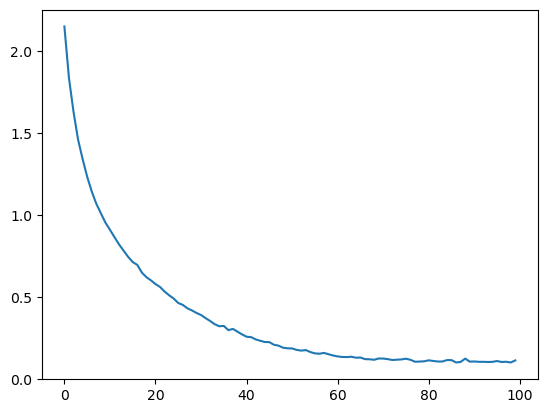

In [57]:
import matplotlib.pyplot as plt

plt.plot(torch.arange(len(losses_plt)), losses_plt)

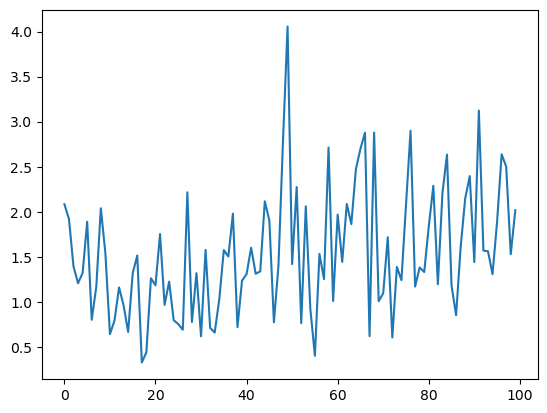

In [58]:
plt.plot(torch.arange(len(val_loss_plt)), val_loss_plt)

In [59]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

test_loader_2 = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader_2))
predictions = model(X_batch).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       330
           1       0.47      0.72      0.57        32
           2       0.24      0.25      0.24        87
           3       0.32      0.37      0.34        49
           4       0.70      0.61      0.65       572
           5       0.38      0.13      0.20        38
           6       0.46      0.50      0.48       117
           7       0.47      0.52      0.49        27
           8       0.42      0.26      0.32        39
           9       0.57      0.64      0.60       120
          10       0.77      0.77      0.77       153
          11       0.00      0.00      0.00         8
          12       0.35      0.30      0.32        27
          13       0.00      0.00      0.00         9
          14       0.75      0.81      0.78       502
          15       0.00      0.00      0.00        23
          16       0.31      0.33      0.32        46
          17       0.67    

In [60]:
# Проверяем работу модели на наших данных
names_list = [
    "Demenchuk",
    "Baranov",
    "Fogel",
    "Newman"
]

targets_list = ["Russian","Russian", "German", "English"]

for name, target in zip(map(lambda x: x.lower(), names_list), targets_list):
    x = torch.LongTensor(train_dataset.processing(name)).unsqueeze(0)
    output = model(x).cpu().detach().numpy()
    predictions = output.argsort()[0][-3:][::-1]
    predictions_names = label_encoder.inverse_transform(predictions)
    print(f"Surname : {name}")
    print(f"True    : {target}")
    print(f"Predicts: {predictions}")
    print(f"Predicts names: {predictions_names}\n")
    


Surname : demenchuk
True    : Russian
Predicts: [14  2  6]
Predicts names: ['Russian' 'Czech' 'German']

Surname : baranov
True    : Russian
Predicts: [14  9  2]
Predicts names: ['Russian' 'Italian' 'Czech']

Surname : fogel
True    : German
Predicts: [ 4 14 16]
Predicts names: ['English' 'Russian' 'Spanish']

Surname : newman
True    : English
Predicts: [4 6 1]
Predicts names: ['English' 'German' 'Chinese']



**Вывод** За счет использования Embedding'ов точность модели была увеличина

Было

| macro avg    |  0.39 | 0.36 |  0.36 | 2196 |
| ------------ | ----- | ---- | ----- | ---- |
| weighted avg | 0.65  | 0.66 | 0.64  | 2196 |

Стало

| macro avg    | 0.47 | 0.40 | 0.42 | 2196 |
| ------------ | ---- | ---- | ---- | ---- |
| weighted avg | 0.68 | 0.69 | 0.68 | 2196 |

## 3. Классификация обзоров на фильмы (ConvNet)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`


2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [61]:
from nltk.tokenize import word_tokenize, sent_tokenize

In [62]:
def file_reader(path) -> list:
    data = []
    with open(path) as f:
        for line in f.readlines():
            if line is not None:
                data.append(line)
    return data            

Чистаем данные с файлов

In [63]:
reviews_negative = file_reader("./data/polarity/negative_reviews.txt")
labels_negative = np.zeros(shape=len(reviews_negative), dtype=int)
labels_negative[-1]

0

In [64]:
len(reviews_negative)

5331

In [65]:
len(labels_negative)

5331

In [66]:
reviews_positive = file_reader("./data/polarity/positive_reviews.txt")
labels_positive = np.zeros(shape=len(reviews_positive), dtype=int)
labels_positive.fill(1)
labels_positive[-1]

1

In [67]:
len(reviews_positive)

5331

In [68]:
len(labels_positive)

5331

In [69]:
reviews = reviews_negative + reviews_positive
labels = np.concatenate((labels_negative, labels_positive), axis=0)

In [70]:
len(reviews)

10662

In [71]:
len(labels)

10662

In [72]:

n_classes = 2
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)


In [73]:
class Vocab:
    def __init__(self, data, unk_token: str = "<UNK>"):
        self.max_seq_len = 0
        tokens = set()
        for item in data:
            words = [word for word in word_tokenize(self.preprocess_text(item))]
            if len(words) > self.max_seq_len:
                self.max_seq_len = len(words)
            tokens.update(words)
        if unk_token is not None:
            tokens.add(unk_token)
        self.idx_to_token = dict(enumerate(tokens, 1))
        self.idx_to_token[0] = "<PAD>"
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)

    def preprocess_text(self, text):
        return re.sub(r"[^a-zA-Z,!?\.]", " ", text.lower())


In [74]:
class ReviewsDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def to_indices(self, review):
        seq = [
            self.vocab.token_to_idx[token]
            if token in self.vocab.token_to_idx.keys()
            else self.vocab.token_to_idx["<PAD>"]
            for token in word_tokenize(review)
        ]
        if len(seq) < self.vocab.max_seq_len:
            seq.extend(
                [self.vocab.token_to_idx["<PAD>"]] * (self.vocab.max_seq_len - len(seq))
            )
        else:
            seq = seq[: self.vocab.max_seq_len]
        return torch.LongTensor(seq)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.to_indices(self.X[idx]), self.y[idx]


In [75]:
vocab = Vocab(X_train)
print(vocab.vocab_len)

16368


In [76]:
train_dataset = ReviewsDataset(X_train, y_train, vocab)
test_dataset = ReviewsDataset(X_test, y_test, vocab)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [77]:
class ReviewModel(nn.Module):
    def __init__(self, embed_num, embed_dim, classes_num, seq_len, use_embed=True):
        super(ReviewModel, self).__init__()

        self.embed_dim = embed_dim
        self.use_embed = use_embed
        self.seq_len = seq_len
        if self.use_embed:
            self.embed = nn.Embedding(embed_num, embed_dim)
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=256, kernel_size=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(64, classes_num)

    def forward(self, x):
        if self.use_embed:
            x = self.embed(x)

        x = x.reshape(len(x), self.embed_dim, self.seq_len).type(torch.FloatTensor)
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x, _ = x.max(dim=-1)

        return self.fc1(x)


In [78]:
model = ReviewModel(vocab.vocab_len, 180, n_classes, vocab.max_seq_len, use_embed=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
n_epochs = 40

losses_plt = []
val_loss_plt = []

for epoch in range(n_epochs):
    print(f"\n-------------------------------\nEpoch {epoch+1}")
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch).item()
            acc = accuracy_score(
                y_batch, predictions.argmax(dim=1).cpu().detach()
            ).item()
            
            train_loss = epoch_loss / len(train_loader)
            val_loss += loss
            val_acc += acc
            print(
                f"Training loss: {train_loss:>7f} val_loss: {val_loss:>7f}"
            )
            
    val_loss_plt.append(loss)
    losses_plt.append(train_loss)



-------------------------------
Epoch 1
Training loss: 0.709015 val_loss: 0.700078
Training loss: 0.709015 val_loss: 1.403056
Training loss: 0.709015 val_loss: 2.103761
Training loss: 0.709015 val_loss: 2.813574
Training loss: 0.709015 val_loss: 3.524901
Training loss: 0.709015 val_loss: 4.238843
Training loss: 0.709015 val_loss: 4.997329
Training loss: 0.709015 val_loss: 5.730058
Training loss: 0.709015 val_loss: 6.453776
Training loss: 0.709015 val_loss: 7.160521
Training loss: 0.709015 val_loss: 7.834644
Training loss: 0.709015 val_loss: 8.537939
Training loss: 0.709015 val_loss: 9.258697
Training loss: 0.709015 val_loss: 9.963609
Training loss: 0.709015 val_loss: 10.642958
Training loss: 0.709015 val_loss: 11.335549
Training loss: 0.709015 val_loss: 12.051269

-------------------------------
Epoch 2
Training loss: 0.697271 val_loss: 0.699051
Training loss: 0.697271 val_loss: 1.388772
Training loss: 0.697271 val_loss: 2.093843
Training loss: 0.697271 val_loss: 2.780834
Training los

Training loss: 0.629153 val_loss: 7.769976
Training loss: 0.629153 val_loss: 8.461191
Training loss: 0.629153 val_loss: 9.165245
Training loss: 0.629153 val_loss: 9.875149
Training loss: 0.629153 val_loss: 10.577210
Training loss: 0.629153 val_loss: 11.260525
Training loss: 0.629153 val_loss: 11.949845

-------------------------------
Epoch 12
Training loss: 0.623072 val_loss: 0.716575
Training loss: 0.623072 val_loss: 1.430997
Training loss: 0.623072 val_loss: 2.102660
Training loss: 0.623072 val_loss: 2.803429
Training loss: 0.623072 val_loss: 3.528295
Training loss: 0.623072 val_loss: 4.247081
Training loss: 0.623072 val_loss: 4.952256
Training loss: 0.623072 val_loss: 5.657339
Training loss: 0.623072 val_loss: 6.364135
Training loss: 0.623072 val_loss: 7.044367
Training loss: 0.623072 val_loss: 7.756070
Training loss: 0.623072 val_loss: 8.473854
Training loss: 0.623072 val_loss: 9.177216
Training loss: 0.623072 val_loss: 9.876401
Training loss: 0.623072 val_loss: 10.561155
Training

Training loss: 0.567173 val_loss: 3.510267
Training loss: 0.567173 val_loss: 4.217786
Training loss: 0.567173 val_loss: 4.941423
Training loss: 0.567173 val_loss: 5.641833
Training loss: 0.567173 val_loss: 6.335777
Training loss: 0.567173 val_loss: 7.037569
Training loss: 0.567173 val_loss: 7.748761
Training loss: 0.567173 val_loss: 8.466717
Training loss: 0.567173 val_loss: 9.167474
Training loss: 0.567173 val_loss: 9.856428
Training loss: 0.567173 val_loss: 10.571624
Training loss: 0.567173 val_loss: 11.278918
Training loss: 0.567173 val_loss: 11.992394

-------------------------------
Epoch 23
Training loss: 0.561832 val_loss: 0.715038
Training loss: 0.561832 val_loss: 1.410586
Training loss: 0.561832 val_loss: 2.104318
Training loss: 0.561832 val_loss: 2.820882
Training loss: 0.561832 val_loss: 3.521676
Training loss: 0.561832 val_loss: 4.226759
Training loss: 0.561832 val_loss: 4.949069
Training loss: 0.561832 val_loss: 5.633158
Training loss: 0.561832 val_loss: 6.327326
Training 

Training loss: 0.517056 val_loss: 11.298513
Training loss: 0.517056 val_loss: 12.018654

-------------------------------
Epoch 33
Training loss: 0.512367 val_loss: 0.710687
Training loss: 0.512367 val_loss: 1.426316
Training loss: 0.512367 val_loss: 2.158155
Training loss: 0.512367 val_loss: 2.857552
Training loss: 0.512367 val_loss: 3.540635
Training loss: 0.512367 val_loss: 4.209452
Training loss: 0.512367 val_loss: 4.918925
Training loss: 0.512367 val_loss: 5.644155
Training loss: 0.512367 val_loss: 6.337000
Training loss: 0.512367 val_loss: 7.057053
Training loss: 0.512367 val_loss: 7.798562
Training loss: 0.512367 val_loss: 8.500226
Training loss: 0.512367 val_loss: 9.199509
Training loss: 0.512367 val_loss: 9.900499
Training loss: 0.512367 val_loss: 10.625449
Training loss: 0.512367 val_loss: 11.309719
Training loss: 0.512367 val_loss: 11.996653

-------------------------------
Epoch 34
Training loss: 0.507450 val_loss: 0.688842
Training loss: 0.507450 val_loss: 1.413850
Training

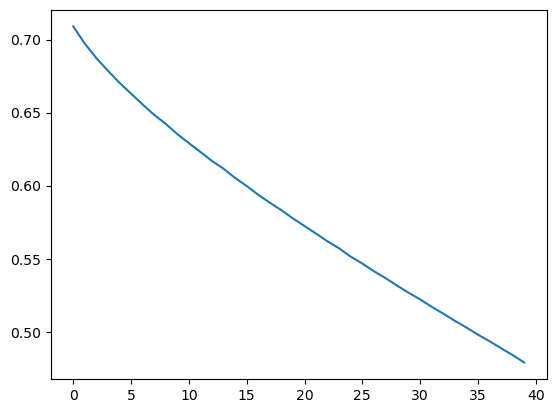

In [79]:
plt.plot(torch.arange(len(losses_plt)), losses_plt)

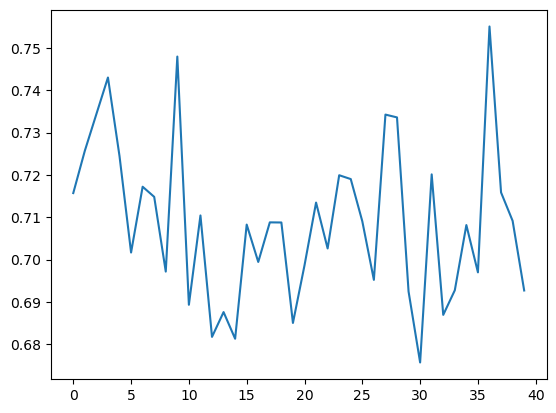

In [80]:
plt.plot(torch.arange(len(val_loss_plt)), val_loss_plt)

In [81]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

test_loader_2 = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader_2))
predictions = model(X_batch).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))


              precision    recall  f1-score   support

           0       0.50      0.53      0.52      1022
           1       0.55      0.52      0.53      1111

    accuracy                           0.53      2133
   macro avg       0.53      0.53      0.52      2133
weighted avg       0.53      0.53      0.53      2133



In [85]:
reviews_list = [
    """WOW! this was amazing!
normally i don’t do reviews but i’m just so blown away. from the casting to the acting to the set design to the plot and storyline, wednesday has completely left me speechless in the best way! i grew up watching the addams family movies and loving them for how weird and odd and endearing they were, this fits right in.
spoilers from here on just in case anyone hasn’t seen it! please please PLEASE go watch it, i promise you won’t be disappointed :)
    """,

    
"""This is a poor CW teen drama show. The quirkiness of the family is gone and in its stead is a dramatic mystery with relationship woes and attempts at suspenseful foreshadowing. While Thing is animated wonderfully, the prosthetics are far below par for even for a budget TV show, and animation for anything they plan to show for less than a minute is of a painful quality. The characters are rewritten in what seems like an attempt to make them fit with a teen drama dynamic. Rather than Morticia and Wednesday's loving yet at times adversarial relationship that still comes across as being very close to each other, they've cranked the adversarial part to 11 and turned both Gomez and Morticia into a type of "The adults you must rebel against". With this you no longer have the Addams family vs. The world, but rather Wednesday and her band of misfits Vs. The non understanding adults and the mean kids at school (I.E. Every Teen Drama). Speaking of her family, we also have Pugsly. Pugsly and Wednesday have always gotten into shared antics with Wednesday usually coming out on top. These were ways to highlight both of their near invulnerability while also having fun and showing their sadistic side in a cooky and zany way. Well, now Pugsly is instead this squeamish incapable child, who is mostly just used as a catalyst to have Wednesday unleash her wrath upon someone. """,
]


targets_list = ["Positive", "Negative"]
targets_dict = {1:"Positive", 0: "Negative"}


for review, target in zip(reviews_list, targets_list):

    x = train_dataset.to_indices(review).unsqueeze(0)
    predictions = model(x).argmax(dim=1).cpu().detach()
    predictions_str = targets_dict[predictions.item()]
    
    print(f"Review: \n{review[:100]}..")
    print(f"True    : {target}")
    print(f"Predicts: {predictions}")
    print(f"Predicts string: {predictions_str}\n")


Review: 
WOW! this was amazing!
normally i don’t do reviews but i’m just so blown away. from the casting to t..
True    : Positive
Predicts: tensor([1])
Predicts string: Positive

Review: 
This is a poor CW teen drama show. The quirkiness of the family is gone and in its stead is a dramat..
True    : Negative
Predicts: tensor([0])
Predicts string: Negative

